# Harmonic Phasor Estimation with Quadrature Demodulation

As discussed in previous blog posts, voltage and current waveforms on AC power systems are often modeled as ideal sinusoids at a single fundamental frequency (either 50 or 60 Hz). However, in the modern electric grid, this model is often not reflective of the true shape of these waveforms. Many modern consumer devices (e.g. laptop chargers), as well as inverter-based renewable energy sources, rely on power electronics. As opposed to traditional loads, these power electronics have non-linear behavior, and distort the voltage and current waveforms of the grid by introducing harmonic components (sinusoidal components that oscillate at an integer multiple of the fundamental frequency). 

## Harmonic Distortion

Waveforms can become "distorted" by harmonics, causing phasor approximations to break down as waveforms look less and less like perfect sinusoids. This blog post describes one approach (called Quadrature Demodulation) for decomposing a signal into its harmonic components.

## Dataset Used

To demonstrate the approach, we will look at the point-on-wave data for a 50 Hz current waveform measured at the EPFL campus [1]. Current waveforms tend to have higher levels of harmonic distortion, and this particular dataset shows a current waveform with a relatively large but not abnormal amount of harmonic distortion.

In [1]:
# Import python libraries

import btrdb
from btrdb.utils.timez import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import signal

## Get & Plot Data from NI4AI

In [2]:
# Define helper function

def points2series(points, raw=True):
    """Unpacks datapoints into an array of times and an array of values"""
    times, values = [], []
    t0 = points[0].time
    for point in points:
        times.append(point.time/1e9) #time in seconds
        if raw:
            values.append(point.value)
        else:
            values.append(point.mean)
    return np.array(values), np.array(times)

In [3]:
db = btrdb.connect()

epfl_data = db.streams_in_collection("POW/EPFL", tags = {"name": "ia1"})

start = epfl_data[0].earliest()[0].time + ns_delta(seconds=12)
interval = ns_delta(seconds=1)
end = start + interval
pw = 1 #this number should be <15 to get the raw data

# Extract values and timestamps from data
points, _ = zip(*epfl_data[0].values(start, end))
pow_data, times = points2series(points, raw=True)

ts_datetimes = [ns_to_datetime(time_point*1e9) for time_point in times]

dt = (times[-1]-times[0])/len(times)
fs = 1/dt

In [4]:
print("Sample Rate: %i Hz"%(fs))

Sample Rate: 50000 Hz


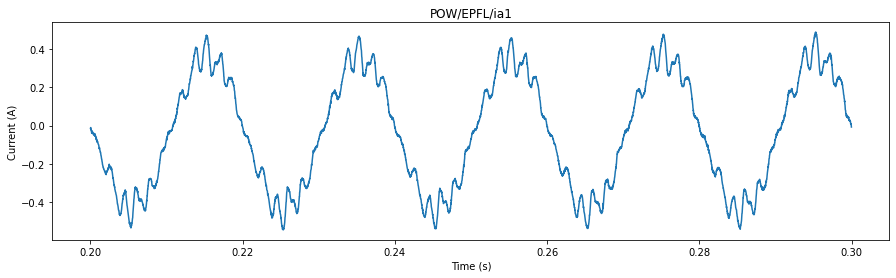

In [5]:
start_plot = 10000
end_plot = 15000
plt.figure(figsize=(15,4))
plt.plot(times[start_plot:end_plot] - times[0], pow_data[start_plot:end_plot])
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("POW/EPFL/ia1")
plt.show()

## Calculating phasors

If we try to model this waveform as a synchrophasor, we see that the model of this signal as a single sine wave doesn't really reflect the true shape of the waveform. Here, we define a helper function for calculating a phasor approximation of the raw waveform data.

In [6]:
# Define helper function

def gen_phasor(times, pow_data, f):
    """Uses quadrature demodulation to estimate the fundamental phasor of a system
    Returns: phasor amplitude (amp) and phase angle (ph)
    """
    fs = (len(times) - 1)/ (times[-1]-times[0])
    
    # define in-phase & quadrature signals
    r_i = np.cos(times*2*np.pi*f)
    r_q = np.sin(times*2*np.pi*f)

    y_i = pow_data * r_i
    y_q = pow_data * r_q

    # filter out higher freq components
    sos = signal.butter(6, f, btype='low', output='sos', fs=fs)
    y_i = signal.sosfiltfilt(sos, y_i, padtype=None)
    y_q = signal.sosfiltfilt(sos, y_q, padtype=None)
    
    # calculate amplitude & phase
    amp = 2*np.sqrt(y_i**2 + y_q**2)
    ph = -np.arctan2(y_q, y_i)
    
    return amp, ph

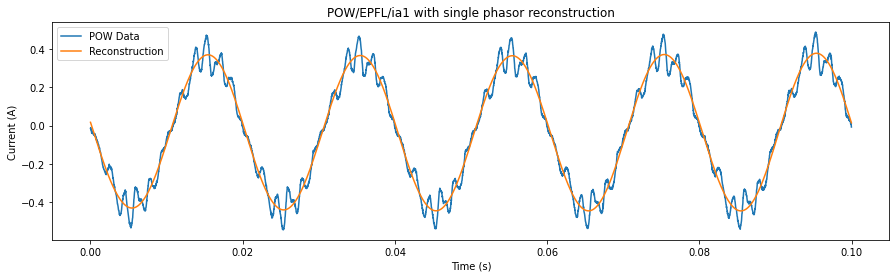

In [7]:
# estimate 50 Hz phasor parameters for data
amp, ph = gen_phasor(times, pow_data, 50)

# reconstruct fundamental frequency from phasor
recon = amp*np.cos(2*np.pi*50*times + ph)

# plotting
plt.figure(figsize=(15,4))
plt.plot(times[start_plot:end_plot] - times[start_plot], pow_data[start_plot:end_plot], label="POW Data")
plt.plot(times[start_plot:end_plot] - times[start_plot], recon[start_plot:end_plot], label="Reconstruction")
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("POW/EPFL/ia1 with single phasor reconstruction")
plt.legend()
plt.show()

As shown in the plot above, the point-on-wave signal has many higher-frequency oscillations caused by the presence of the harmonics that aren't reflected by the traditional single-phasor estimation. These harmonic components in the voltage and current do not contribute any net real power, so characterizing the harmonics is an important issue with regards to power quality. Often, all of the harmonic components of a given signal are described with a single number, called the total harmonic distortion (THD), which describes the relative magnitude of the harmonic components of a signal compared to the magnitude of the component of the signal at the fundamental frequency. The THD reflects the impact that the harmonic distortion in a signal has on power quality, but not much else. An alternative way to represent the harmonic components of a signal is to represent each harmonic component individually as its own phasor, at its own harmonic frequency. This representation gives more detailed information about the harmonics present, potentially making it possible to analyze the cause of the harmonics or directly counteract them. 

## Quadrature Demodulation for Harmonic Analysis
One method for determining the harmonic content of a waveform is to use a technique commonly used in telecommunication called quadrature demodulation [2]. This method is used to estimate the phasor parameters of a signal at any given frequency by essentially shifting the frequency spectrum of the signal to the left so the frequency of interest is centered at 0, and low-pass filtering the shifted signal to isolate the magnitude and phase of the signal at the specific frequency.

In [8]:
def quad_demod(times, pow_data, f, base_f):
    
    # estimate sampling frequency
    fs = (len(times) - 1)/ (times[-1]-times[0])
    
    # define in-phase & quadrature signals
    r_i = np.cos(times*2*np.pi*f)
    r_q = np.sin(times*2*np.pi*f)

    y_i = pow_data * r_i     # real part of signal with shifted frequency spectrum
    y_q = pow_data * r_q     # imaginary part of signal with shifted frequency spectrum

    # filter out higher freq components
    sos = signal.butter(6, base_f, btype='low', output='sos', fs=fs)
    y_i = signal.sosfiltfilt(sos, y_i, padtype=None)
    y_q = signal.sosfiltfilt(sos, y_q, padtype=None)
    
    # calculate amplitude & phase
    amp = 2*np.sqrt(y_i**2 + y_q**2)
    ph = -np.arctan2(y_q, y_i)
    
    return amp, ph

To use quadrature demodulation to describe the harmonic decomposition of the system, we can iteratively apply quadrature demodulation to estimate the frequency at each harmonic frequency of interest, and subtract the reconstruction of that component from our signal before computing the reconstruction of the next harmonic from the remainder.

In [9]:
def estimate_harmonics_quad(times, pow_data, harm_freqs, base_f):
    """Inputs
       -------------
       times: numpy array of timestamps of data
       pow_data: numpy array of point-on-wave data
       harm_freqs: list of harmonic frequencies to be estimated
       base_f: fundamental frequency of the signal
       
       Returns:
       -------------
       amps: a 2D list where the i-th row contains the amplitude of the
             i-th harmonic to be estimated at each time-step in times
       phs: a 2D list where the i-th row contains the phase of the
            i-th harmonic to be estimated at each time-step in times
       recon: a numpy array containing the point-on-wave data reconstructed 
              from the harmonics generated"""
    
    # initialize data
    residual = pow_data
    amps = []
    phs = []
    recon = 0


    for harm_f in harm_freqs:
        # estimate amplitude and phase of each harmonic frequency
        amp, ph = quad_demod(times, residual, harm_f, base_f)
        
        # update reconstruction
        harm_recon = amp*np.cos(times*2*np.pi*harm_f + ph)
        recon += harm_recon
        
        # subtracted estimated component from signal
        residual = residual - harm_recon
        
        amps.append(amp)
        phs.append(ph)
        
    return amps, phs, recon

When we estimate the harmonic content of the signal, we can get a much better reconstruction of the shape of the waveform. The plots below show the reconstruction of the same point-on-wave data with various number of harmonics taken into account. Note that here we only estimate the odd harmonics (i.e. 1\*50 Hz, 3\*50 Hz, 5\*50 Hz, etc.), because power electronics generally tend to only inject the odd harmonics into the grid.

As seen below, as we add more harmonics, we can better characterize the higher frequency oscillations that take place within each period of the data.

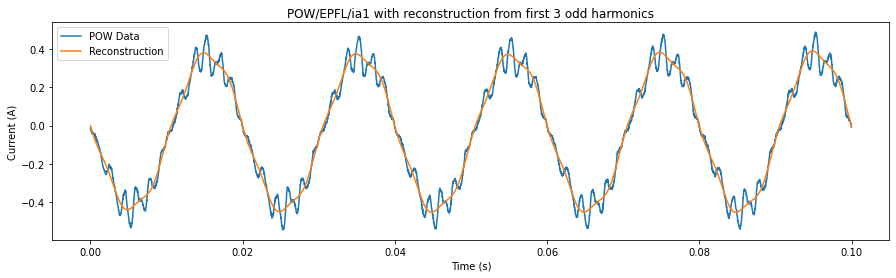

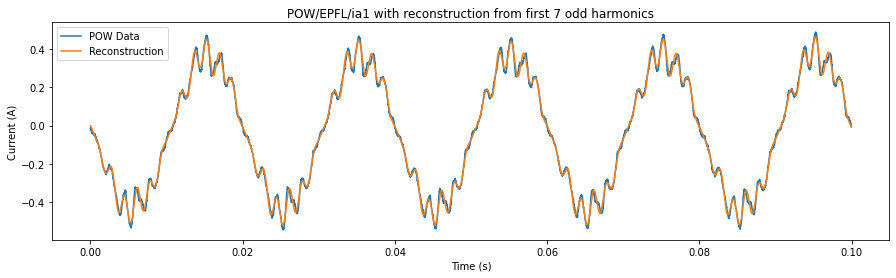

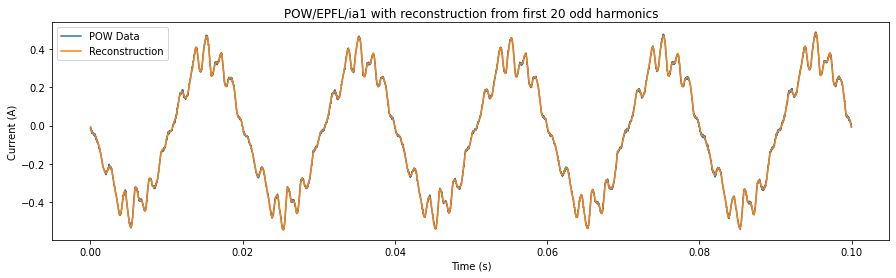

In [10]:
# plot reconstruction for various numbers of harmonics
for n in [3, 7, 20]:
    # estimate the first n odd harmonics
    harm_freqs = range(50, (50 + n*100), 100)
    amps, phs, recon = estimate_harmonics_quad(times, pow_data, harm_freqs, 50)

    # plot reconstruction
    plt.figure(figsize=(15,4))
    plt.plot(times[start_plot:end_plot] - times[start_plot], pow_data[start_plot:end_plot], label="POW Data")
    plt.plot(times[start_plot:end_plot] - times[start_plot], recon[start_plot:end_plot], label="Reconstruction")
    plt.xlabel("Time (s)")
    plt.ylabel("Current (A)")
    plt.title(f"POW/EPFL/ia1 with reconstruction from first {n} odd harmonics")
    plt.legend()
    plt.show()

With this analysis, we can also break down our signal into its individual harmonic components. The plot below shows a few of the higher magnitude harmonic components of the signal plotted together. This decomposition into the primary harmonic components allows us to analyze more specifically the type of harmonic distortion present in the grid.

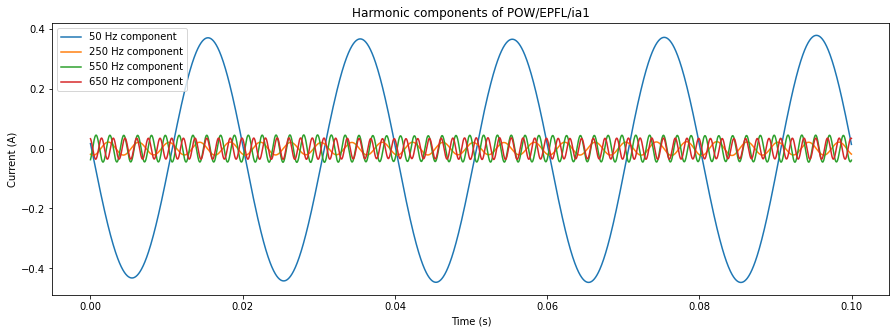

In [11]:
# calculate harmonic phasors for first 20 odd harmonics
n = 20
harm_freqs = range(50, (50 + n*100), 100)
amps, phs, recon = estimate_harmonics_quad(times, pow_data, harm_freqs, 50)

plt.figure(figsize=(15,5))

# for a few selected harmonics
for i in [0, 2, 5, 6]: 
    # use harmonic phasors to generate reconstruction
    recon_i = amps[i]*np.cos(2*np.pi*harm_freqs[i]*times + phs[i])
    plt.plot(times[start_plot:end_plot] - times[start_plot], 
             recon_i[start_plot:end_plot], label=f"{harm_freqs[i]} Hz component")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title(f"Harmonic components of POW/EPFL/ia1")
plt.show()

# References
[1] DESL-EPFL, “Point-on-wave Data of EPFL-campus Distribution Network.” [Online]. Available: https://github.com/DESL-EPFL/. Accessed: 2022-02-14

[2] D. Saba, M. Rusch, D. M. Laverty, and A. von Meier, ”Iterative Quadrature Demodulation for Harmonic Synchrophasor Estimation,” under review, for 2022 International Conference on Smart Grid Synchronized Measurements and Analytics.